In [1]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
%matplotlib inline
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist # computing the distance
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import fcluster
from pyclustertend import hopkins

In [2]:
data = pd.read_csv('Data/PCA_data.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)
print(data.shape)
data.head()

(388, 22)


,stats_PC1,stats_PC2,stats_PC3,PLAYER,TEAM,POSITION,defense_PC1,defense_PC2,defense_PC3,defense_PC4,...,hustle_PC3,shooting_PC1,shooting_PC2,shooting_PC3,shooting_PC4,play_PC1,play_PC2,play_PC3,play_PC4,passing_PC1
0,4.674833,7.289013,-0.240604,James Harden,HOU,G,1.158709,0.981086,-0.437014,1.681691,...,-0.032227,4.206455,0.278324,-2.018788,-0.306612,-4.313970,7.210947,7.787175,-0.991071,3.953771
1,3.480394,4.225621,-1.915357,Paul George,OKC,F,-0.076796,0.535884,-2.617200,-0.221552,...,-0.676752,4.416718,-1.115199,-1.817118,-0.525678,-3.955110,4.054167,0.200333,-0.100192,1.005878
2,8.126167,3.767512,-0.602605,Giannis Antetokounmpo,MIL,F,0.249371,-0.582274,-1.575326,0.891747,...,-0.965400,0.303794,3.404961,-2.447429,-0.232322,0.195494,5.351138,0.568888,-1.022542,2.473767
3,7.534206,1.957477,-0.880680,Joel Embiid,PHI,F-C,5.025456,2.818697,-1.269017,1.760690,...,-0.555207,2.051242,3.143054,-1.197058,-0.411250,3.201982,5.586363,-0.428772,-1.627686,1.292996
4,4.158587,5.603268,0.412803,LeBron James,LAL,F,-0.445747,-1.033204,-1.126382,1.967757,...,0.492583,2.451034,1.030243,-2.751712,-0.747411,-1.127836,5.025539,2.697098,-0.559131,3.520363


In [3]:
def Standard_Scaler_Preprocess(data):    
    std_scale = StandardScaler()
    std_scale_data = std_scale.fit_transform(data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1))
    std_scale_data = pd.DataFrame(std_scale_data, columns = data.drop(['PLAYER', 'TEAM', 'POSITION'], axis = 1).columns.tolist())
    std_scale_data['PLAYER'] = data['PLAYER']
    std_scale_data['TEAM'] = data['TEAM']
    std_scale_data['POSITION'] = data['POSITION']
    return std_scale_data

data_scaled = Standard_Scaler_Preprocess(data)
data_scaled.head()

,stats_PC1,stats_PC2,stats_PC3,defense_PC1,defense_PC2,defense_PC3,defense_PC4,hustle_PC1,hustle_PC2,hustle_PC3,...,shooting_PC3,shooting_PC4,play_PC1,play_PC2,play_PC3,play_PC4,passing_PC1,PLAYER,TEAM,POSITION
0,1.906326,3.609709,-0.192583,0.565387,0.615901,-0.331497,1.406358,1.840183,-0.891263,-0.032676,...,-1.995970,-0.318566,-1.393048,3.286738,4.699478,-0.708825,2.665098,James Harden,HOU,G
1,1.419252,2.092638,-1.533079,-0.037472,0.336414,-1.985274,-0.185279,3.299036,-1.309305,-0.686188,...,-1.796580,-0.546172,-1.277167,1.847883,0.120899,-0.071659,0.678027,Paul George,OKC,F
2,3.313728,1.865770,-0.482334,0.121680,-0.365537,-1.194961,0.745746,2.091442,0.271179,-0.978860,...,-2.419767,-0.241380,0.063128,2.439040,0.343318,-0.731334,1.667479,Giannis Antetokounmpo,MIL,F
3,3.072335,0.969393,-0.704909,2.452151,1.769507,-0.962611,1.472423,1.477774,2.664616,-0.562947,...,-1.183528,-0.427284,1.033970,2.546256,-0.258759,-1.164139,0.871563,Joel Embiid,PHI,F-C
4,1.695809,2.774885,0.330413,-0.217501,-0.648619,-0.854415,1.645588,1.038331,-0.561106,0.499450,...,-2.720610,-0.776550,-0.364196,2.290633,1.627670,-0.399897,2.372952,LeBron James,LAL,F


In [4]:
data_scaled.describe().round(1)

,stats_PC1,stats_PC2,stats_PC3,defense_PC1,defense_PC2,defense_PC3,defense_PC4,hustle_PC1,hustle_PC2,hustle_PC3,shooting_PC1,shooting_PC2,shooting_PC3,shooting_PC4,play_PC1,play_PC2,play_PC3,play_PC4,passing_PC1
count,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0,388.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
min,-2.7,-2.2,-2.3,-1.7,-2.9,-2.6,-3.2,-1.9,-1.6,-1.2,-2.6,-2.7,-3.7,-5.3,-1.7,-2.2,-3.1,-2.4,-1.6
25%,-0.7,-0.7,-0.7,-0.7,-0.7,-0.7,-0.6,-0.8,-0.7,-0.6,-0.7,-0.7,-0.6,-0.6,-0.8,-0.6,-0.6,-0.7,-0.8
50%,-0.2,-0.1,-0.1,-0.2,-0.0,0.0,0.0,-0.1,-0.4,-0.3,-0.1,-0.1,-0.0,-0.1,-0.3,-0.1,-0.1,-0.1,-0.2
75%,0.6,0.5,0.6,0.5,0.6,0.6,0.7,0.7,0.3,0.2,0.5,0.5,0.6,0.6,0.6,0.6,0.6,0.6,0.6
max,3.5,3.6,2.9,3.3,3.6,3.4,3.3,3.3,4.5,8.4,3.3,3.4,4.1,5.4,2.5,3.3,4.7,3.6,3.1


In [5]:
num_data_scaled = data_scaled.drop(['PLAYER', 'POSITION', 'TEAM'], axis = 1)
num_data_scaled.columns

Index(['stats_PC1', 'stats_PC2', 'stats_PC3', 'defense_PC1', 'defense_PC2',
       'defense_PC3', 'defense_PC4', 'hustle_PC1', 'hustle_PC2', 'hustle_PC3',
       'shooting_PC1', 'shooting_PC2', 'shooting_PC3', 'shooting_PC4',
       'play_PC1', 'play_PC2', 'play_PC3', 'play_PC4', 'passing_PC1'],
      dtype='object')

In [6]:
hopkins(num_data_scaled, num_data_scaled.shape[0])

0.2535952084239313

In [7]:
class cluster:
    def __init__(self, method):
        self.method = method
        self.linked = linkage(num_data_scaled, self.method)


    def cophenet_value(self):
        c, coph_dists = cophenet(self.linked, pdist(num_data_scaled))
        return c
    

    def dendrogram_plot(self):
        plt.figure(figsize=(15, 6)) 
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('States')
        plt.ylabel('distance')
        dendrogram(self.linked,
                   orientation='top', #The direction to plot the dendrogram
                              #The root at the top, and descendent links going downwards
                   #labels=statesList,
                   distance_sort='descending',
                   show_leaf_counts=True)
        plt.show()

    def dendrogram_truncated(self, n, y_min = 0, max_d = 0):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index')
        plt.ylabel('distance')
        dendro = dendrogram(
                    self.linked,
                    truncate_mode='lastp',  # show only the last p merged clusters
                    p=n,  # show only the last p merged clusters
                    leaf_rotation=90.,
                    leaf_font_size=12.,
                    show_contracted=True,  # to get a distribution impression in truncated branches
                )

        for i, d, c in zip(dendro['icoord'], dendro['dcoord'], dendro['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            #if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                         textcoords='offset points',
                         va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')

        plt.ylim(ymin = y_min)
        plt.show()


    def inconsistency(self):
        depth = 3
        incons = inconsistent(self.linked, depth)
        return incons[-15:]


    def elbow_plot(self, cut = 0):
        last = self.linked[(-1*cut):, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        plt.plot(idxs, last_rev)

        acceleration = np.diff(last, 2)  # 2nd derivative of the distances
        self.acceleration_rev = acceleration[::-1]
        plt.plot(idxs[:-2] + 1, self.acceleration_rev)
        plt.show()
    

    def elbow_point(self):
        k = self.acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
        return k

    
    def create_cluster(self, max_d):
        clusters = fcluster(self.linked, max_d, criterion='distance')
        return clusters


0.5619047434678657


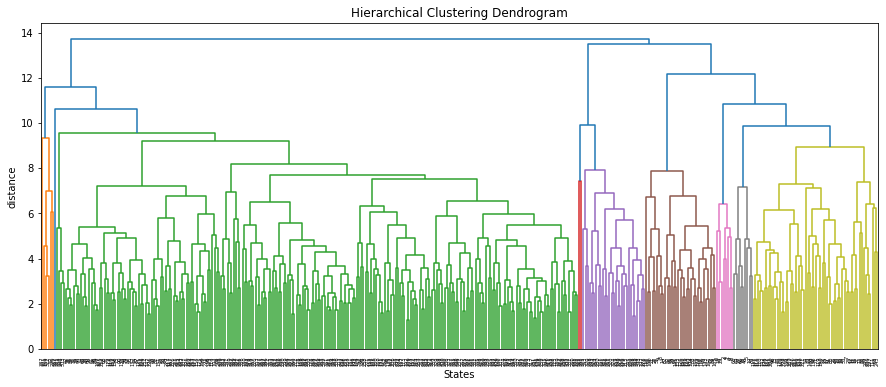

In [8]:
complete = cluster('complete')
print(complete.cophenet_value())
complete.dendrogram_plot()

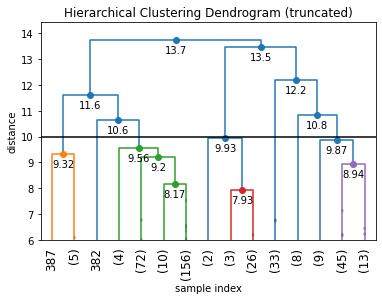

In [9]:
complete.dendrogram_truncated(15, 6, 10)

In [10]:
complete.inconsistency()

array([[ 6.194803  ,  1.09889173,  6.        ,  1.51897014],
       [ 5.87685228,  1.48299673,  6.        ,  1.38394679],
       [ 6.78100753,  1.16443908,  7.        ,  1.19147259],
       [ 6.99647523,  1.06877905,  7.        ,  1.81721615],
       [ 7.34568131,  1.19198136,  7.        ,  1.55749793],
       [ 6.73649395,  1.9965905 ,  4.        ,  1.29368338],
       [ 7.15591686,  2.36872162,  6.        ,  1.01508572],
       [ 7.19494859,  1.8754117 ,  7.        ,  1.4277681 ],
       [ 7.50291764,  1.6688088 ,  5.        ,  1.45165833],
       [ 8.68288103,  2.31064824,  4.        ,  0.84285809],
       [ 7.69082482,  2.21739114,  7.        ,  1.41749901],
       [ 9.62215937,  1.72592916,  5.        ,  1.14712494],
       [ 8.66726842,  2.28874727,  7.        ,  1.53102125],
       [ 9.94592534,  2.34612179,  7.        ,  1.50633061],
       [11.5519607 ,  1.70039081,  7.        ,  1.28385873]])

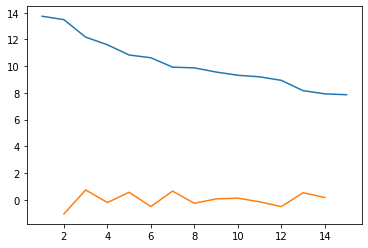

In [11]:
complete.elbow_plot(15)

In [12]:
complete.elbow_point()

3

In [13]:
data_scaled['complete_cluster'] = complete.create_cluster(10)

In [14]:
data_scaled.groupby('complete_cluster').mean()

,stats_PC1,stats_PC2,stats_PC3,defense_PC1,defense_PC2,defense_PC3,defense_PC4,hustle_PC1,hustle_PC2,hustle_PC3,shooting_PC1,shooting_PC2,shooting_PC3,shooting_PC4,play_PC1,play_PC2,play_PC3,play_PC4,passing_PC1
complete_cluster,,,,,,,,,,,,,,,,,,,
1,0.386097,-0.577954,0.037086,1.195698,-0.376952,0.881226,-0.175060,-0.114479,0.792986,4.621917,-0.405806,-0.060871,-0.449807,0.063393,1.095655,-0.229445,-0.188383,0.193727,-0.396433
2,-0.451892,-0.164058,-0.205447,-0.348625,-0.243817,-0.029116,-0.081075,-0.343512,-0.280307,-0.147533,-0.108581,-0.391642,0.096856,0.120894,-0.219189,-0.326599,-0.210917,-0.213397,-0.303441
3,-2.740969,-0.242264,0.243872,-1.568877,0.119724,-1.185937,0.239452,-1.488351,-0.370395,0.654801,-1.538745,-2.670227,1.251615,-5.260254,-0.288602,-1.369551,-1.237510,0.774197,-1.254476
4,0.912447,-1.416561,1.037749,1.100384,-0.797837,0.871974,0.087208,-0.686227,1.336542,0.179348,-1.231972,1.176109,0.605962,-0.131318,1.566308,-0.120249,0.418162,1.056754,-0.904676
5,1.896006,-0.443436,-0.141143,2.100440,0.507072,-0.056855,0.176615,0.914807,2.266592,-0.356953,0.007365,1.566136,-0.605311,0.218813,1.739083,1.088866,-0.051033,0.134270,-0.143503
6,1.661288,2.469388,-0.184788,-0.096470,0.234477,-1.072430,0.626715,1.799295,-0.744020,-0.389716,1.814486,0.868589,-1.438223,-0.622952,-0.836143,1.983823,1.591714,-0.840583,2.023980
7,0.084148,1.226920,0.346531,-0.356609,1.004023,-0.203445,0.102770,0.925301,-0.698977,0.248569,0.801230,0.040629,-0.138743,-0.336459,-0.783548,0.503102,0.438762,0.287163,1.397828


In [15]:
data_scaled['complete_cluster'].value_counts()

2    242
7     67
5     33
4     31
6      8
1      6
3      1
Name: complete_cluster, dtype: int64

0.5873799009553569


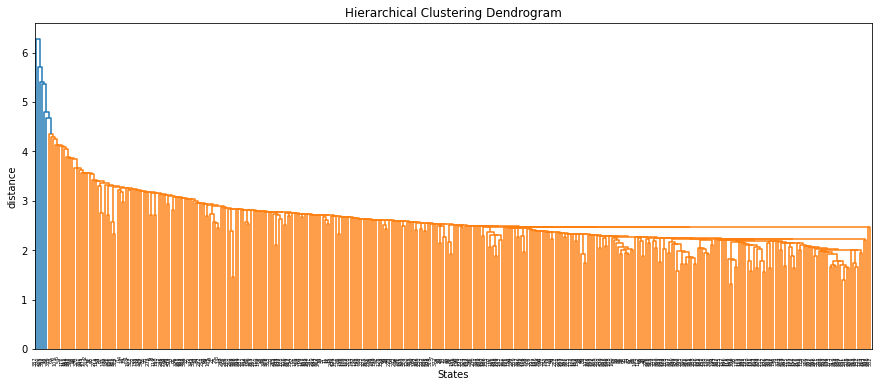

In [16]:
single = cluster('single')
print(single.cophenet_value())
single.dendrogram_plot()

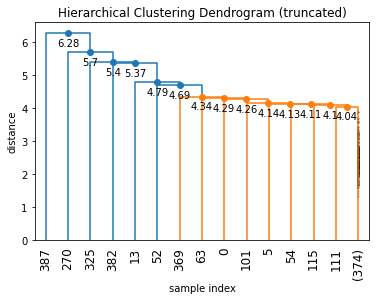

In [17]:
single.dendrogram_truncated(15)

In [18]:
single.inconsistency()

array([[3.87392251, 0.01366715, 3.        , 1.15276742],
       [3.93278758, 0.09513858, 3.        , 1.14635009],
       [4.01026588, 0.10830717, 3.        , 0.82177861],
       [4.08278142, 0.0356703 , 3.        , 0.6852409 ],
       [4.11220746, 0.01602091, 3.        , 1.11855944],
       [4.12582459, 0.0168657 , 3.        , 0.84770966],
       [4.17628523, 0.07146686, 3.        , 1.15187448],
       [4.23026277, 0.07983635, 3.        , 0.77405396],
       [4.29851049, 0.04348967, 3.        , 1.06587337],
       [4.44068295, 0.2133318 , 3.        , 1.14582318],
       [4.60702268, 0.23313446, 3.        , 0.78948828],
       [4.9471807 , 0.36599039, 3.        , 1.14253909],
       [5.18711601, 0.34354836, 3.        , 0.63401084],
       [5.49030422, 0.18323222, 3.        , 1.1479424 ],
       [5.79668565, 0.44757316, 3.        , 1.08987244]])

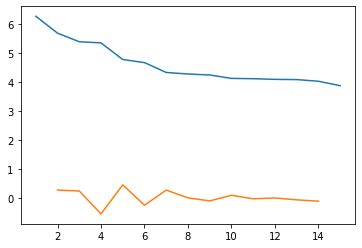

5


In [19]:
single.elbow_plot(15)
print(single.elbow_point())

0.6920334946668971


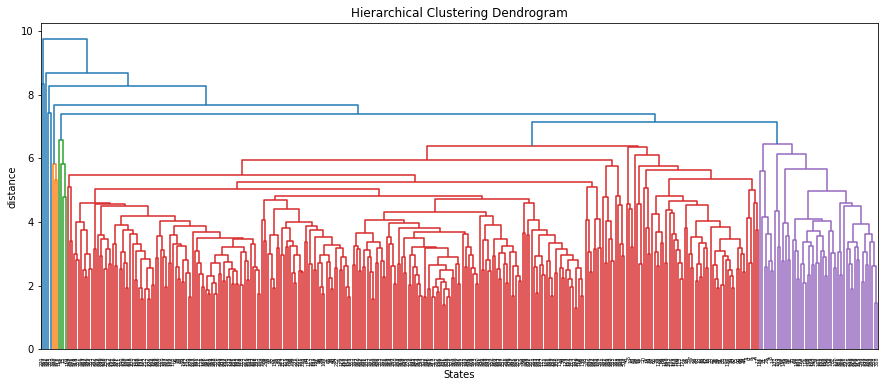

In [20]:
average = cluster('average')
print(average.cophenet_value())
average.dendrogram_plot()

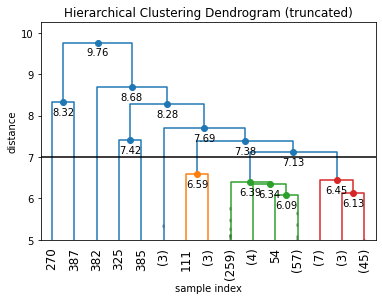

In [21]:
average.dendrogram_truncated(15, 5, 7)

In [22]:
average.inconsistency()

array([[5.30042472, 0.45291199, 7.        , 1.46021965],
       [5.51642924, 0.65438496, 4.        , 0.87596202],
       [4.71350526, 1.08768916, 6.        , 1.30271722],
       [5.42884964, 0.89534061, 5.        , 1.01790554],
       [5.79287912, 0.6334995 , 7.        , 0.93754066],
       [5.38981358, 0.93567619, 6.        , 1.12984574],
       [5.72964441, 0.90126877, 3.        , 0.95271298],
       [6.28363052, 0.47479932, 7.        , 1.77326041],
       [6.62228882, 0.5603598 , 6.        , 1.34596221],
       [7.41746794, 0.        , 1.        , 0.        ],
       [6.65439333, 0.92505008, 6.        , 1.11885254],
       [7.31581277, 0.90981629, 5.        , 1.05472858],
       [8.31956111, 0.        , 1.        , 0.        ],
       [8.01618575, 0.57049434, 4.        , 1.16789822],
       [8.76033161, 0.6934419 , 4.        , 1.44719642]])

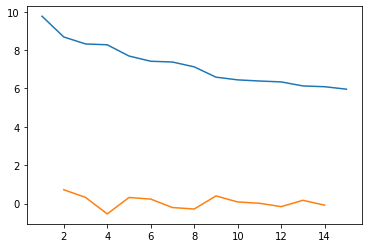

2


In [23]:
average.elbow_plot(15)
print(average.elbow_point())

In [24]:
data_scaled['average_cluster'] = average.create_cluster(7)

In [25]:
data_scaled.groupby('average_cluster').mean()

,stats_PC1,stats_PC2,stats_PC3,defense_PC1,defense_PC2,defense_PC3,defense_PC4,hustle_PC1,hustle_PC2,hustle_PC3,shooting_PC1,shooting_PC2,shooting_PC3,shooting_PC4,play_PC1,play_PC2,play_PC3,play_PC4,passing_PC1,complete_cluster
average_cluster,,,,,,,,,,,,,,,,,,,,
1,-0.076168,-0.901428,-0.778191,0.882070,-0.164012,0.811497,0.662552,0.216446,-0.029481,8.374556,-0.636260,-0.694070,-0.365495,-0.935211,0.832422,0.003887,-0.913423,0.544182,-0.849463,1.000000
2,-1.651323,-1.097263,1.836928,0.498720,0.112795,3.165488,-2.494701,-1.034165,0.475515,4.595491,-2.478353,0.669304,-3.721632,0.478788,1.092607,-1.837989,1.320632,1.572247,-0.842399,1.000000
3,0.949374,-1.759663,0.327349,1.182764,1.054389,0.904243,-1.777403,-0.193776,1.693608,-0.532408,-1.121429,1.998921,2.466290,5.413545,1.568780,-0.906061,0.401582,1.537183,-0.646829,4.000000
4,-1.526158,-0.027678,2.454298,-0.622617,-0.855980,1.294705,0.905965,-1.401372,-0.484644,0.194121,-0.235139,0.046307,4.107731,2.770388,-0.597784,-1.558609,0.933605,0.889430,-0.124459,4.000000
5,0.413581,-1.035056,1.680996,1.275935,-1.050132,2.502485,-1.097630,-1.399829,1.220373,1.198409,-1.246053,0.430752,1.373147,-1.778343,0.864550,-1.351679,1.075917,1.158577,-0.756638,3.333333
6,1.223335,0.623750,0.044041,0.687311,0.448706,-1.361795,-0.608637,1.590565,0.296185,3.545467,0.097937,0.369005,-1.392599,0.063517,0.543089,0.533734,0.146483,-0.380170,0.557118,5.500000
7,-0.277507,0.153700,-0.076304,-0.328739,-0.004230,-0.073921,-0.001359,-0.053339,-0.354806,-0.090137,0.104946,-0.261743,0.012394,0.024127,-0.317980,-0.092386,-0.033887,-0.101889,0.080677,3.146417
8,1.599836,-0.812711,0.276184,1.792293,0.044480,0.303243,0.156867,0.342912,1.959315,-0.038721,-0.442385,1.489106,-0.113928,-0.093293,1.721787,0.677169,0.119258,0.462436,-0.402513,4.436364
9,-2.740969,-0.242264,0.243872,-1.568877,0.119724,-1.185937,0.239452,-1.488351,-0.370395,0.654801,-1.538745,-2.670227,1.251615,-5.260254,-0.288602,-1.369551,-1.237510,0.774197,-1.254476,3.000000


In [26]:
data_scaled['average_cluster'].value_counts()

7    321
8     55
6      4
5      3
9      1
4      1
3      1
2      1
1      1
Name: average_cluster, dtype: int64

0.5087705567242806


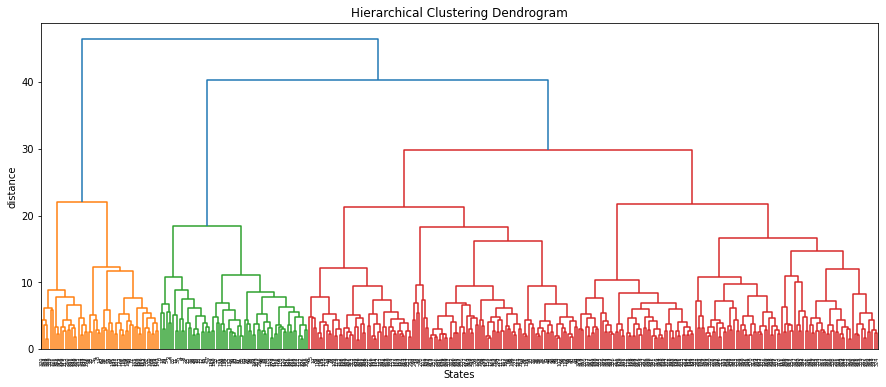

In [27]:
ward = cluster('ward')
print(ward.cophenet_value())
ward.dendrogram_plot()

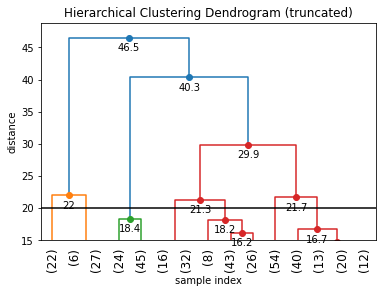

In [28]:
ward.dendrogram_truncated(15, 15, 20)

In [29]:
ward.inconsistency()

array([[ 6.24933237,  2.80995975,  7.        ,  1.92872492],
       [ 7.24857707,  2.64833129,  6.        ,  1.78660475],
       [ 7.42620457,  2.67747829,  7.        ,  1.75255259],
       [ 7.07900113,  3.6866045 ,  7.        ,  1.41796518],
       [ 9.93191658,  2.91693141,  7.        ,  1.62376313],
       [ 8.65416129,  3.76876095,  7.        ,  1.99955446],
       [11.73351627,  3.12980056,  7.        ,  1.58631337],
       [11.05121222,  4.38647743,  7.        ,  1.63761957],
       [10.21830812,  3.97978729,  7.        ,  2.0495996 ],
       [13.54958516,  5.09649111,  7.        ,  1.52697854],
       [12.9031435 ,  5.04795104,  7.        ,  1.73572065],
       [10.58464648,  5.68106133,  7.        ,  2.01024602],
       [18.62111993,  6.54097757,  7.        ,  1.72102877],
       [21.94580478, 10.43699163,  7.        ,  1.76258559],
       [25.47157492, 14.09836795,  7.        ,  1.49092294]])

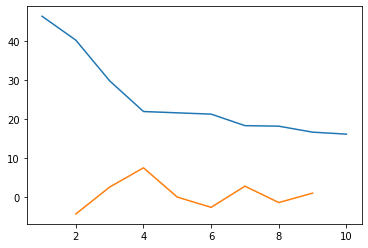

4


In [30]:
ward.elbow_plot(10)
print(ward.elbow_point())

In [31]:
data_scaled['ward_cluster'] = ward.create_cluster(20)

In [32]:
data_scaled.groupby('ward_cluster').mean()

,stats_PC1,stats_PC2,stats_PC3,defense_PC1,defense_PC2,defense_PC3,defense_PC4,hustle_PC1,hustle_PC2,hustle_PC3,...,shooting_PC2,shooting_PC3,shooting_PC4,play_PC1,play_PC2,play_PC3,play_PC4,passing_PC1,complete_cluster,average_cluster
ward_cluster,,,,,,,,,,,,,,,,,,,,,
1,1.085922,-1.436726,1.167923,1.286255,-0.734707,1.065109,-0.155141,-0.721323,1.483334,0.135179,...,1.391882,0.682791,-0.848954,1.624939,-0.090563,0.529124,1.157548,-0.869061,3.909091,7.590909
2,1.896006,-0.443436,-0.141143,2.100440,0.507072,-0.056855,0.176615,0.914807,2.266592,-0.356953,...,1.566136,-0.605311,0.218813,1.739083,1.088866,-0.051033,0.134270,-0.143503,5.000000,8.000000
3,0.179848,1.434224,0.340796,-0.426782,1.023421,-0.274036,0.165378,0.942643,-0.775054,-0.095174,...,0.155714,-0.135955,-0.307725,-0.898449,0.654150,0.800872,0.122330,1.568764,6.231884,7.000000
4,-0.587606,0.106550,-0.801198,-0.657251,0.209463,0.056233,-0.168663,-0.207101,-0.519776,-0.207846,...,-0.796441,0.036510,0.464271,-0.837959,0.071407,-1.249304,0.838683,-0.076647,2.520833,7.000000
5,0.177891,-0.103460,-0.599020,0.224340,0.014034,-0.709380,-0.211621,0.476346,-0.087516,0.156349,...,-0.163118,-0.452667,0.068241,0.066241,0.311395,-0.502471,-0.723392,-0.183361,2.324675,6.922078
6,-0.865825,0.214129,0.875859,-0.846068,-0.244261,0.614672,0.069180,-0.728342,-0.548691,0.152410,...,-0.336840,0.833106,-0.175573,-0.564229,-0.602093,0.800844,-0.164840,0.091313,2.314815,6.944444
7,-0.442423,-0.722718,-0.085481,-0.096502,-0.813301,0.189213,0.080337,-0.785520,0.086649,0.059766,...,-0.283172,0.028822,0.172124,0.405229,-0.870217,-0.115359,-0.164612,-0.841445,2.270588,6.905882


In [33]:
data_scaled['ward_cluster'].value_counts()

7    85
5    77
3    69
6    54
4    48
2    33
1    22
Name: ward_cluster, dtype: int64

In [35]:
data_scaled = data_scaled[['stats_PC1', 'stats_PC2', 'stats_PC3', 'defense_PC1', 'defense_PC2', 'defense_PC3', 'defense_PC4', 'hustle_PC1',                                 'hustle_PC2', 'hustle_PC3', 'shooting_PC1', 'shooting_PC2', 'shooting_PC3', 'shooting_PC4', 'play_PC1', 'play_PC2',                              'play_PC3', 'play_PC4', 'passing_PC1', 'PLAYER', 'TEAM', 'POSITION', 'ward_cluster']]
data_scaled.rename({'ward_cluster' : 'CLUSTER'}, axis = 1, inplace = True)
data_scaled.to_csv('Clustered_data.csv', index = False)